# Tutorial 3: The Numerical Sandbox, Extension Experiment (Mesh deform version)

**Romain Beucher**
Version 0.1

romain.beucher@anu.edu.au

The following notebook is an implementation of the Numerical Sandbox Extension Experiment similar to [Buiter et al., 2006](http://sp.lyellcollection.org/content/253/1/29). The test is commonly referred as one of the GEOMOD benchmarks and is used to test the large deformation viscous-plastic behaviour of geodynamic numerical codes.

The initial purpose of the GEOMOD numerical experiments was to compare results from analog and numerical experiments. It is not a numerical benchmark sensus-stricto.

The test has been implemented using Fantom in [Thieulot, 2011](http://linkinghub.elsevier.com/retrieve/pii/S0031920111001336) and more recently with Aspect in [Glerum et al., 2017](http://www.solid-earth-discuss.net/se-2017-9). 

![title](images/underworld.png)

Results for Underworld from this notebook

A | B
- | - 
![title](images/ExtensionA.png) | ![title](images/ExtensionB.png) 

Results for the extension experiment after 2cm extension (Buiter et al., 2006)

In [1]:
import UWGeodynamics as GEO
u = GEO.UnitRegistry

velocity = 2.5 * u.centimeter / u.hour
model_length = 20. * u.centimeter
bodyforce = 1560 * u.kilogram / u.metre**3 * 9.81 * u.meter / u.second**2

KL = model_length
Kt = KL / velocity
KM = bodyforce * KL**2 * Kt**2

GEO.scaling_coefficients["[length]"] = KL
GEO.scaling_coefficients["[time]"] = Kt
GEO.scaling_coefficients["[mass]"]= KM

loaded rc file /opt/venv/lib/python3.7/site-packages/UWGeodynamics/uwgeo-data/uwgeodynamicsrc


# Model Geometry

Set-up of the extension experiment. A viscous layer (PDMS, 10 x 0.5 cm) lies in the central part of the model on the base. The rest of the model consists of three ‘sand’ layers (only differing in colour). Extension is achieved by moving the right wall with the attached 10 cm long sheet outwards to the right.

<img src="images/Extension.png" width=800>

We use a uniform resolution of 0.2 cm (400 x 100 elements)

In [4]:
Model = GEO.Model(elementRes=(120, 30), 
                  minCoord=(0. * u.centimeter, -3.5 * u.centimeter), 
                  maxCoord=(20. * u.centimeter, 1.5 * u.centimeter), 
                  gravity=(0.0, -9.81 * u.meter / u.second**2))

Model.mesh_advector(axis=0)

Model.outputDir="outputs_tutorial3B"

Model.add_visugrid(elementRes=(120, 30), 
                   minCoord=(0. * u.centimeter, -3.5 * u.centimeter), 
                   maxCoord=(20. * u.centimeter, 0.0 * u.centimeter))

# Add some Materials

Now that we have our "universe" (box, sand pit) ready, we need to fill it with some materials.
The *geodynamics* module is designed around that idea of materials, which are essentially a way to define physical properties across the Model domain.

A material (or a phase) is first defined by the space it takes in the box (its shape).

In [8]:
air = Model.add_material(name="Air", shape=GEO.shapes.Layer(top=Model.top, bottom=Model.bottom))
sand1 = Model.add_material(name="Sand1", shape=GEO.shapes.Layer(top=0.*u.centimeter, bottom=Model.bottom))
sand2 = Model.add_material(name="Sand2", shape=GEO.shapes.Layer(top=-1. * u.centimeter, bottom=-2. * u.centimeter))

vertices = [( 5.* u.centimeter, -3.0 * u.centimeter),
            (15.* u.centimeter, -3.0 * u.centimeter),
            (15.* u.centimeter, -3.5 * u.centimeter),
            ( 5.* u.centimeter, -3.5 * u.centimeter)]

silicon = Model.add_material(name="Silicon", shape=GEO.shapes.Polygon(vertices))

## Passive Tracers

In [9]:
import numpy as np

npoints = 1000

coords = np.ndarray((npoints, 2))
coords[:, 0] = np.linspace(GEO.nd(Model.minCoord[0]), GEO.nd(Model.maxCoord[0]), npoints)
coords[:, 1] = GEO.nd(sand1.top)

Model.add_passive_tracers(name="Interface1", vertices=coords)

coords[:, 1] = GEO.nd(sand2.top)
Model.add_passive_tracers(name="Interface2", vertices=coords)

coords[:, 1] = GEO.nd(sand2.bottom)
Model.add_passive_tracers(name="Interface3", vertices=coords)


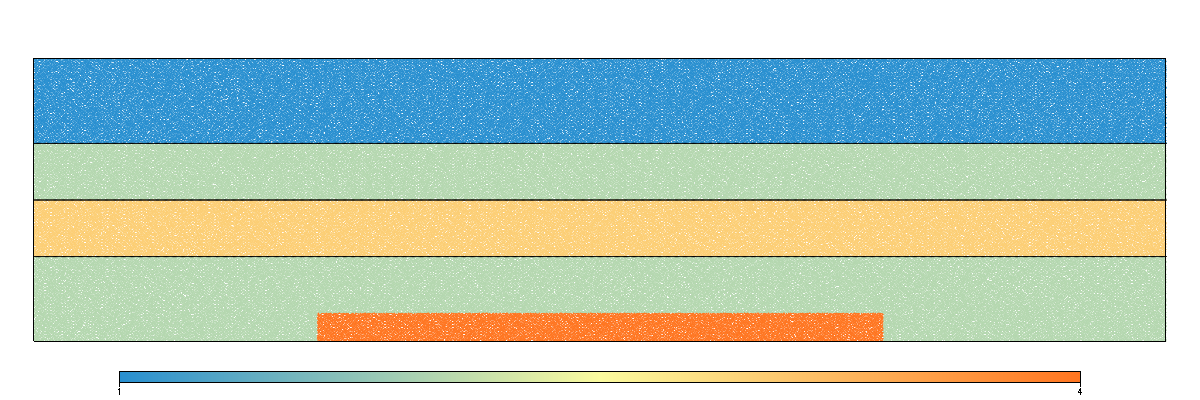

In [10]:
from UWGeodynamics import visualisation as vis
Fig = vis.Figure(figsize=(1200,400))
Fig.Points(Model.Interface1_tracers, pointSize=2.0)
Fig.Points(Model.Interface2_tracers, pointSize=2.0)
Fig.Points(Model.Interface3_tracers, pointSize=2.0)
Fig.Points(Model.swarm, Model.materialField, fn_size=2.0)
Fig.Mesh(Model._visugrid.mesh)
Fig.show()

# Define Viscosities

Viscosities can be defined as a Quantity or a simple scalar value. It is also possible to load predefined rheologies from the rheology_library. 

The rheology library contains some commonly used rheologies stored in a python dictionary structure. We can list the keys defining the rheologies as follows:

In [12]:
# Define densities
air.density = 10. * u.kilogram / u.metre**3
sand1.density = 1560. * u.kilogram / u.metre**3
sand2.density = 1560. * u.kilogram / u.metre**3
silicon.density = 965. * u.kilogram / u.metre**3

# Scalar viscosities
air.viscosity     = 1.0e2  * u.pascal * u.second
sand1.viscosity   = 1.0e13 * u.pascal * u.second
sand2.viscosity   = 1.0e13 * u.pascal * u.second
silicon.viscosity = 5.0e4  * u.pascal * u.second

# Define Plasticity

In contrast to elastic deformation, plastic deformation is permanent (and so is viscous deformation). 
What sets plastic deformation from viscous flow is the idea of a yield stress.
The yield stress is a stress threshold, below which no deformation takes place.
Above the yield stress, the material deforms according to a different flow law.

## The Ducker-Prager yeild stress

The most common type of plastic yield stress in geodynamic simulations is a Drucker-Prager relationship.
The yield stress $\sigma_y$ is defined as

$$
\sigma_y = C \cos \phi + P\sin \phi
$$

where $C$ is cohesion, $\phi$ is friction angle, and $P$ is pressure.
The main parameters we can set are cohesion and friction angle.
For both quantities, higher values produce a stronger plastic material.
In 2D, this equation is the same as the Mohr-Coulomb equation.
Rocks commonly have $C$ values between zero and 20 MPa and $\phi$ between zero and 30 degrees (~0.5 radians).

Our room temperature sand here is a bit different from rocks at high pressures and temperatures.
Perfectly dry sand would have a cohesion close to zero (moisture and interparticle electric forces would increase it a bit).
Friction angle depends on things like grain size, sorting, and shape, but it is generally pretty high in sand.
The angle of repose approximates the friction angle.
Sand has an angle of repose between 30 and 45 degrees (~0.5 to 0.8 radians), depending on how wet it is.

## Strain softening

Plastic yielding in models is meant to approximate the behavior of brittle faults in the real world.
Even though the two processes (plastic yielding and brittle failure) are distinctly different in reality, computer models can't handle discontinuities very well (such as a fault plane).
To approximate the behavior of a faults, we can further tweak the plastic yielding algorithm.
One important characteristic of faults is that, after they form, they become planes of weakness that can be reactivated multiple times during deformation.
As deformation continues, new faults will only be broken if the existing fault planes are not oriented favorably; otherwise, the deformation will concentrate on existing faults.
We introduce strain softening into our plastic deformation scheme to get a similar effect.
Strain softening keeps track of the amount of plastic strain at each location within the model, and reduces the cohesion and/or friction parameters in the Drucker-Prager relationship.
With increasing strain, the friction angle or cohesion decreases toward zero, making the strained material weaker (more easily deformed by plastic yielding).

## Effect on models

The yield stress effectively limits the maximum stress that a cell can experience in the model.
When the stress exceeds that value, the model has to deform in that region.
Weak viscous materials will flow freely even at low stresses, so the yield stress never applies to those materials.
However, strong materials that are not prone to viscous deformation can cause stress to build up, eventually reaching the yield stress and deforming by this plastic mechanism.
The sand in this experiment is an example of a strong material that mainly deforms by plastic yielding.
Strain softening means that regions that have been deformed plastically are more easily deformed again.
This localizes the strain to relatively narrow shear bands.

In [14]:
sandPlasticity = GEO.DruckerPrager(cohesion=10. * u.pascal,
                                     cohesionAfterSoftening=10. * u.pascal,
                                     frictionCoefficient=0.73,
                                     frictionAfterSoftening=0.60)

sand1.plasticity = sandPlasticity
sand2.plasticity = sandPlasticity

# Boundary conditions

+ Basal points above the moving sheet are assigned the velocity of the sheet
+ Basal points to the left of the moving sheet are held fixed. 
+ The change in velocity at the basal velocity discontinuity is accommodated over 0.2 cm. 
+ The sides are not allowed to move vertically.

In [16]:
import underworld.function as fn

conditions = [(Model.x > GEO.nd(10.1 * u.centimetre), GEO.nd(2.5 * u.centimeter / u.hour)),
              (Model.x > GEO.nd(9.9 * u.centimetre), (Model.x - GEO.nd(9.9 * u.centimetre)) * GEO.nd(velocity) / GEO.nd(0.2 * u.centimetre)),
              (True, 0.0)]

fn_condition = fn.branching.conditional(conditions)

Model.set_velocityBCs(left=[0 * u.centimeter / u.hour, None],
                      right=[2.5 * u.centimeter / u.hour, None],
                      bottom=[fn_condition, 0.0])

## Initialise Model

The model is initialize using the *init_model* method which will solve the initial steady state temperature field and the pressure field.

In [17]:
Model.minViscosity = 1.0e2 * u.pascal * u.second
Model.maxViscosity = 1.0e9 * u.pascal * u.second

Model.init_model(pressure="lithostatic")


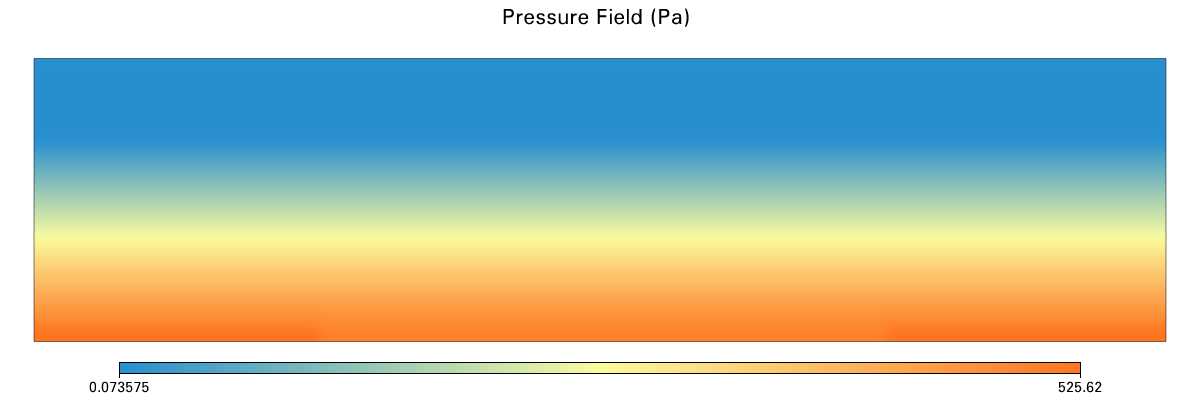

In [22]:
FigPressure = vis.Figure(figsize=(1200, 400), title="Pressure Field (Pa)", quality=3)
FigPressure.Surface(Model.mesh, GEO.dimensionalise(Model.pressureField, u.pascal))
FigPressure.show()


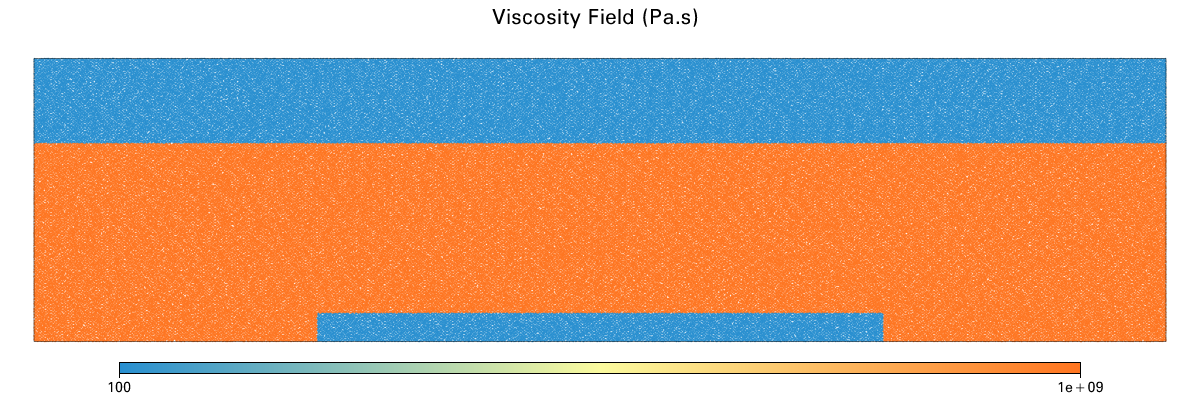

In [21]:
FigViscosity = vis.Figure(figsize=(1200, 400), title="Viscosity Field (Pa.s)", quality=3)
FigViscosity.Points(Model.swarm, GEO.dimensionalise(Model.viscosityField, u.pascal * u.second), pointSize=2.0)
FigViscosity.show()

In [23]:
Model.solver.set_inner_method("mumps")
Model.solver.set_penalty(1e6)
Model.run_for(1.0 * u.hours, checkpoint_interval=10 * u.minutes)

In [ ]:
Fig.show()

In [ ]:
FigViscosity.show()

In [ ]:
FigPressure.show()